# Empirical exploration of ensemble methods

### Questions
> 1. Apply sklearn DecisionTreeClassifier on the egg-yoke dataset and visualize the results with `visualize_classifier` and with sklearn plot_tree.
> 2. By following the algorithm explained [here](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms), retrace the steps that led to this tree.
> 3. The egg-yoke dataset was produced with the sklearn function make_circle. The parameters noise and factor where set to produce a separable dataset. Try noise = 0 to understand how the data is generated. Generate new train and test sets with noise=0.2, factor=0.25, to make the problem more difficult. Fit a tree, visualize and compute generalization error. Generate another train set and repeat. What do you observe.
> 4. *Random forest:* Boostrap allows the simulation of several training samples, by picking n out of m examples with replacement. Bootstrap aggregating (Bagging) classifiers is an ensemble learning methods, which combines the predictors obtained by the same model over bootstraped version of the train set (see Bishop p.656). In the following experiment you will keep only one train set and the test set from the previous question. 
>     1. Using numpy randint, boostrap the train set to obtained two resampled train sets of size 3/4th that of the original dataset. Fit a tree in each resampled train set, visualize and compute generalization error. Combine the decision of both predictors and compute generalization error of the combination.
>     2. Repeat the experiment on a larger scale by using sklearn BaggingClassifier

In [1]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.grid()
    return ax

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.ensemble import BaggingClassifier

In [3]:
RS = 42

### Question 1

In [4]:
# Get train data
train_data = pd.read_csv("eggyoke_traindata.csv")
X_train = train_data[["x_1", "x_2"]].values
y_train = train_data.y

In [5]:
# Get test data
test_data = pd.read_csv("eggyoke_testdata.csv")
X_test = test_data[["x_1", "x_2"]].values
y_test = test_data.y

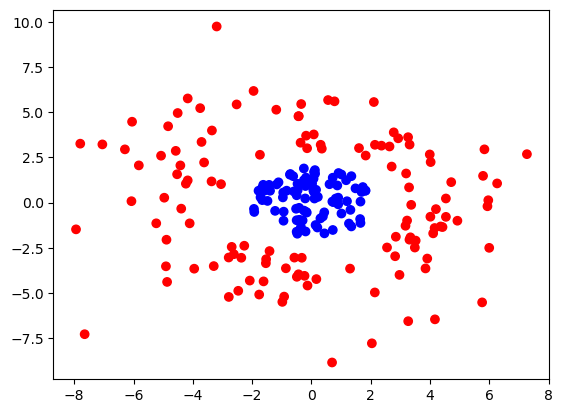

In [6]:
col = {-1:"r", 1:"b"}
plt.scatter(X_train[:,0], X_train[:,1], c=[col[i] for i in y_train])
plt.show()

In [7]:
model = DecisionTreeClassifier(random_state=RS)

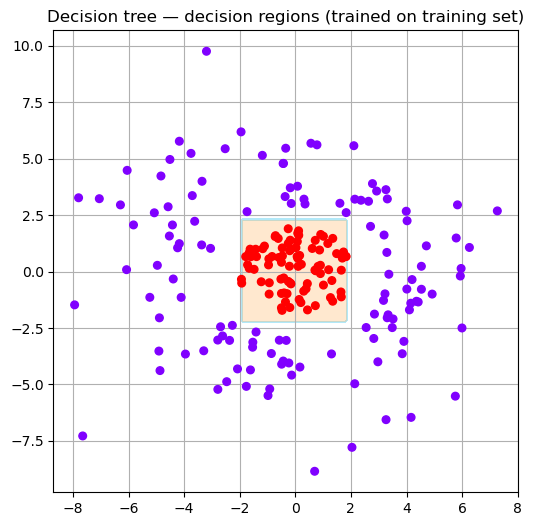

In [8]:
plt.figure(figsize=(6, 6))
visualize_classifier(model, X_train, y_train)
plt.title("Decision tree — decision regions (trained on training set)")
plt.show()

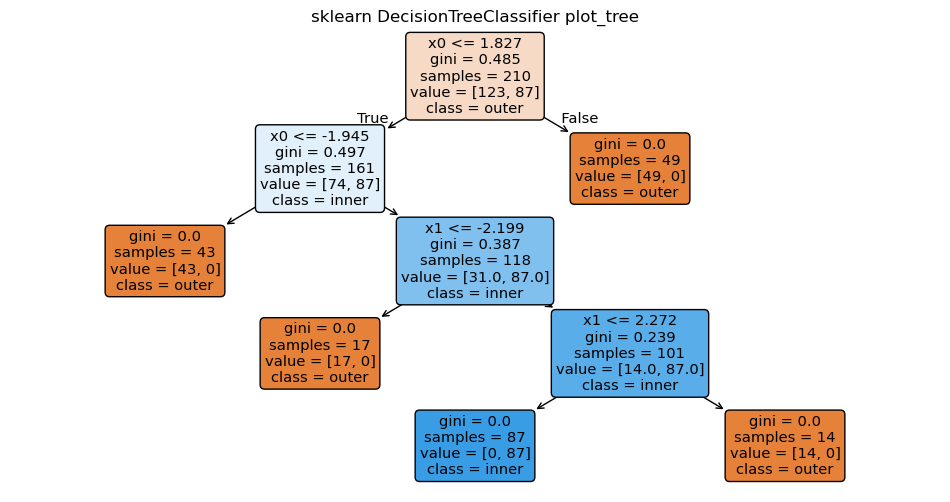

In [9]:
plt.figure(figsize=(12, 6))
plot_tree(model, filled=True, feature_names=['x0','x1'], class_names=['outer','inner'], rounded=True)
plt.title("sklearn DecisionTreeClassifier plot_tree")
plt.show()

### Question 2

In [10]:
def gini(probs):
    return 1.0 - np.sum(probs**2)

In [11]:
def gini_of_labels(labels):
    if len(labels) == 0:
        return 0.0
    _, counts = np.unique(labels, return_counts=True)
    probs = counts / counts.sum()
    return gini(probs)

In [12]:
def best_split_bruteforce(X, y, feature_idx, n_thresholds=200):
    # candidate thresholds: midpoints between sorted unique feature values
    vals = np.sort(np.unique(X[:, feature_idx]))
    if len(vals) <= 1:
        return None
    thresholds = (vals[:-1] + vals[1:]) / 2.0
    # if too few thresholds, use them; else sample evenly
    if len(thresholds) > n_thresholds:
        thresholds = np.linspace(thresholds.min(), thresholds.max(), n_thresholds)
    best = {'threshold': None, 'gain':-np.inf, 'left_idx': None, 'right_idx': None}
    parent_gini = gini_of_labels(y)
    for t in thresholds:
        left_mask = X[:, feature_idx] <= t
        y_left = y[left_mask]
        y_right = y[~left_mask]
        # weighted gini
        n = len(y)
        g_left = gini_of_labels(y_left)
        g_right = gini_of_labels(y_right)
        weighted = (len(y_left)/n)*g_left + (len(y_right)/n)*g_right
        gain = parent_gini - weighted
        if gain > best['gain']:
            best.update({'threshold':t, 'gain':gain, 'left_idx':left_mask, 'right_idx':~left_mask})
    return best

In [13]:
# Get the root split used by sklearn tree (for comparison)
root_feature = model.tree_.feature[0]
root_threshold = model.tree_.threshold[0]

# Brute-force search for best split (per feature)
results = []
for feat in [0,1]:
    res = best_split_bruteforce(X_train, y_train, feat, n_thresholds=500)
    results.append((feat, res))

print("Brute force:")
for feat, res in results:
    print(f"Feature {feat}: best threshold ~ {res['threshold']:.5f}, Gini gain = {res['gain']:.6f}")

# Compare which feature and threshold the brute force finds vs sklearn's root
best_feat, best_info = max(results, key=lambda x: x[1]['gain'])
print("\nBrute force best:")
print(f"    feature: {best_feat}")
print(f"    threshold: {best_info['threshold']}")
print(f"    gain: {best_info['gain']}")
print("sklearn root:")
print(f"    feature: {root_feature}")
print(f"    threshold: {root_threshold}")

if root_feature in [0,1]:
    left_mask = X_train[:, root_feature] <= root_threshold
    g_left = gini_of_labels(y_train[left_mask])
    g_right = gini_of_labels(y_train[~left_mask])
    weighted = (left_mask.sum()/len(y_train))*g_left + ((~left_mask).sum()/len(y_train))*g_right
    print("    gain:", gini_of_labels(y_train) - weighted)

Brute force:
Feature 0: best threshold ~ 1.82655, Gini gain = 0.104472
Feature 1: best threshold ~ -1.80250, Gini gain = 0.098978

Brute force best:
    feature: 0
    threshold: 1.826546396845
    gain: 0.10447204968944085
sklearn root:
    feature: 0
    threshold: 1.8265463709831238
    gain: 0.10447204968944085


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
We manually repeated all the steps required to perform the algorithm
</div>

### Question 3

In [14]:
X, y = make_circles(random_state=42, noise=0)

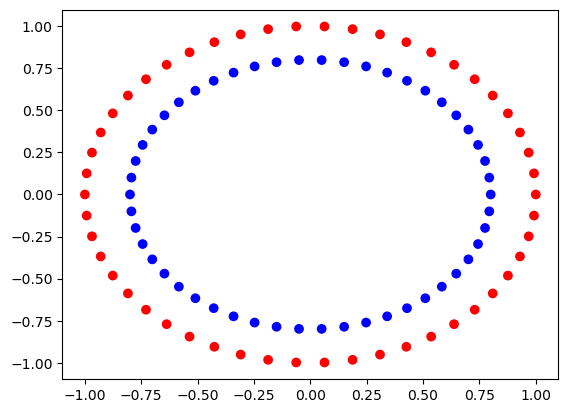

In [15]:
col = {0:"r", 1:"b"}
plt.scatter(X[:,0], X[:,1], c=[col[i] for i in y])
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
With noise=0 we observe ideal circles
</div>

In [16]:
# New dataset with 420 points
X2, y2 = make_circles(random_state=42, noise=0.2, factor=0.25, n_samples=420)

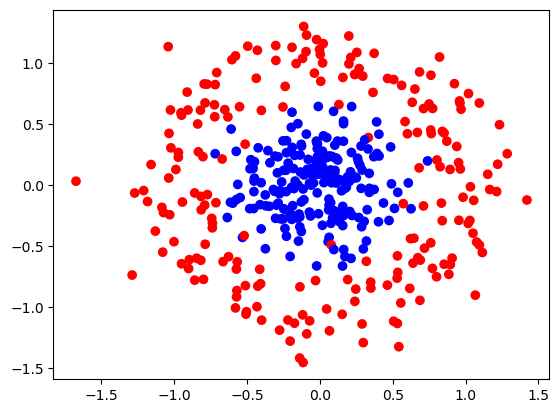

In [17]:
plt.scatter(X2[:,0], X2[:,1], c=[col[i] for i in y2])
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
With noise=0.2 and factor=0.25 the data seems to be non separable anymore (in dim=2)
</div>

In [18]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=RS)

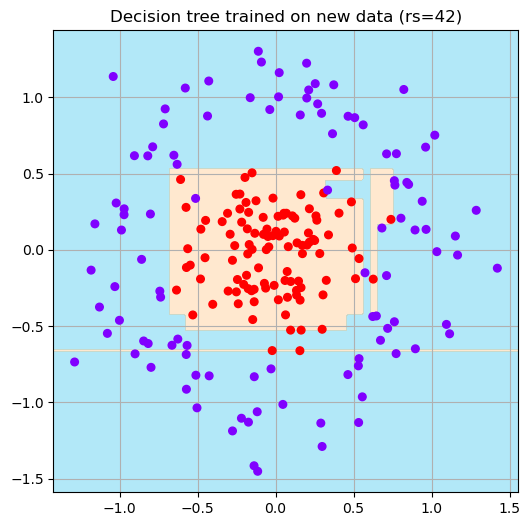

Test accuracy (single tree):
    Original dataset: 0.991
    New dataset:      0.924
Tree depth:
    Original dataset: 4
    New dataset:      9


In [19]:
model2 = DecisionTreeClassifier(random_state=RS)
model2.fit(X2_train, y2_train)

plt.figure(figsize=(6, 6))
visualize_classifier(DecisionTreeClassifier(random_state=RS), X2_train, y2_train)
plt.title("Decision tree trained on new data (rs=42)")
plt.show()

# compare accuracy
acc_orig = accuracy_score(y_test, model.predict(X_test))
acc_new = accuracy_score(y2_test, model2.predict(X2_test))
print("Test accuracy (single tree):")
print(f"    Original dataset: {acc_orig:.3f}")
print(f"    New dataset:      {acc_new:.3f}")

# Quick observation note (display counts)
print("Tree depth:")
print(f"    Original dataset: {model.get_depth()}")
print(f"    New dataset:      {model2.get_depth()}")

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
In contrast to the initial data, the new one is not visually separable anymore. This makes the task more diffucult. We observe that this leads to increase in model complexity (tree depth grows from 4 to 9), and test accuracy drops by several percent. 
</div>

In [20]:
# New dataset - same params, different random state
X3, y3 = make_circles(random_state=0, noise=0.2, factor=0.25, n_samples=420)

In [21]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.5, random_state=RS)

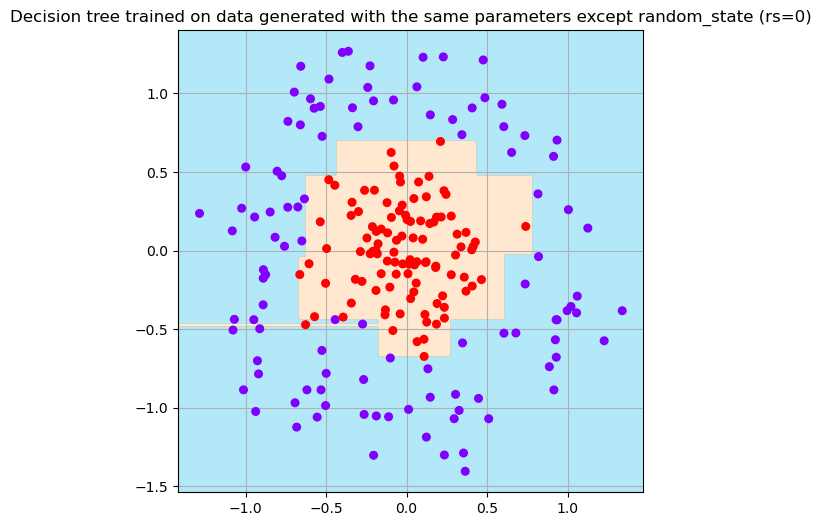

Test accuracy (single tree):
    Data for rs=42: 0.924
    Data for rs=0:  0.948
Tree depth:
    Data for rs=42: 9
    Data for rs=0:  6


In [22]:
model3 = DecisionTreeClassifier(random_state=RS)
model3.fit(X3_train, y3_train)

plt.figure(figsize=(6, 6))
visualize_classifier(DecisionTreeClassifier(random_state=RS), X3_train, y3_train)
plt.title("Decision tree trained on data generated with the same parameters except random_state (rs=0)")
plt.show()

# compare accuracy
acc2 = accuracy_score(y2_test, model2.predict(X2_test))
acc3 = accuracy_score(y3_test, model3.predict(X3_test))
print("Test accuracy (single tree):")
print(f"    Data for rs=42: {acc2:.3f}")
print(f"    Data for rs=0:  {acc3:.3f}")

# Quick observation note (display counts)
print("Tree depth:")
print(f"    Data for rs=42: {model2.get_depth()}")
print(f"    Data for rs=0:  {model3.get_depth()}")

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
The experiment shows that decision trees are highly sensitive to the training set: small changes in the data lead to significantly different tree structures (in our case, the depth dropped from 9 to 6), indicating high variance and motivating the use of ensemble methods such as bagging.
</div>

### Question 4

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
We first write a general function that allows us to create an ensemble of any number of trees. For each tree we use only 3/4 of dataset for training
</div>

In [23]:
def bootstrap_ensemble(X_train, y_train, X_test, n_estimators=25, random_state=RS):
    rng = np.random.RandomState(random_state)
    models = []
    for i in range(n_estimators):
        idx = rng.randint(0, len(X_train), size=int(len(X_train) * 3/4))
        Xt, yt = X_train[idx], y_train[idx]
        clf = DecisionTreeClassifier(random_state=(random_state + i))
        clf.fit(Xt, yt)
        models.append(clf)
    # predict by majority voting for test set
    preds = np.array([m.predict(X_test) for m in models])  # shape (n_estimators, n_test)
    # majority vote
    maj_vote = np.apply_along_axis(lambda col: Counter(col).most_common(1)[0][0], axis=0, arr=preds)
    return models, maj_vote, preds

In [24]:
n_estimators = 2
models_bag, maj_pred, raw_preds = bootstrap_ensemble(X3_train, y3_train, X3_test, n_estimators=n_estimators, random_state=RS)
acc_bag = accuracy_score(y3_test, maj_pred)
acc_single1 = accuracy_score(y3_test, models_bag[0].predict(X3_test))
acc_single2 = accuracy_score(y3_test, models_bag[1].predict(X3_test))
print(f"Single tree 1 test accuracy: {acc_single1:.4f}")
print(f"Single tree 2 test accuracy: {acc_single2:.4f}")
print(f"Bootstrap ensemble ({n_estimators} trees) test accuracy: {acc_bag:.4f}")

Single tree 1 test accuracy: 0.9524
Single tree 2 test accuracy: 0.9429
Bootstrap ensemble (2 trees) test accuracy: 0.9524


In [25]:
class EnsembleWrapper:
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        return self
    def predict(self, Xq):
        # majority vote over the models
        P = np.array([m.predict(Xq) for m in self.models])
        return np.apply_along_axis(lambda col: Counter(col).most_common(1)[0][0], axis=0, arr=P)

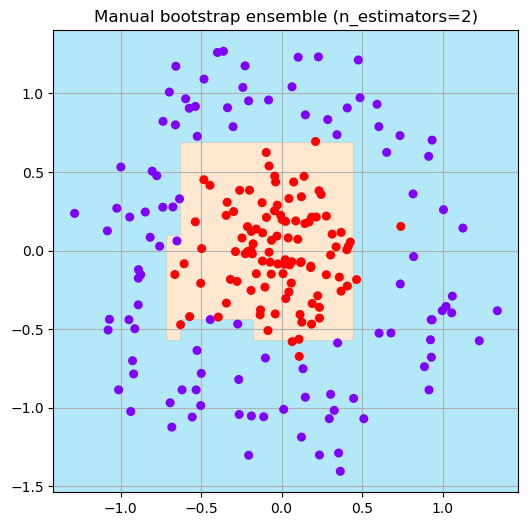

In [26]:
plt.figure(figsize=(6, 6))
visualize_classifier(EnsembleWrapper(models_bag), X3_train, y3_train)
plt.title(f"Manual bootstrap ensemble (n_estimators={n_estimators})")
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
Let's do the same with 101 trees in the ensemble
</div>

In [27]:
n_estimators = 101
models_bag, maj_pred, raw_preds = bootstrap_ensemble(X3_train, y3_train, X3_test, n_estimators=n_estimators, random_state=RS)
acc_bag = accuracy_score(y3_test, maj_pred)
print(f"Bootstrap ensemble ({n_estimators} trees) test accuracy: {acc_bag:.4f}")

Bootstrap ensemble (101 trees) test accuracy: 0.9667


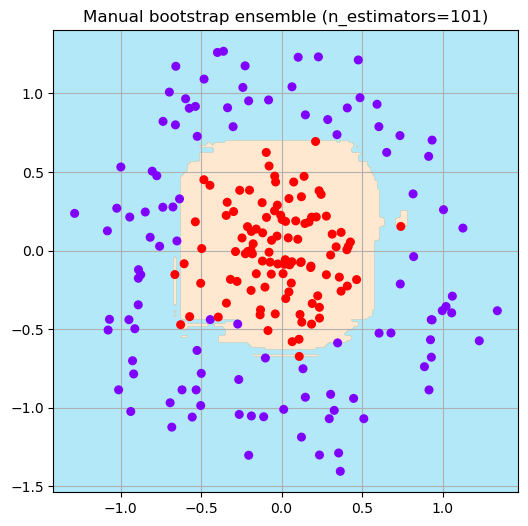

In [28]:
plt.figure(figsize=(6, 6))
visualize_classifier(EnsembleWrapper(models_bag), X3_train, y3_train)
plt.title(f"Manual bootstrap ensemble (n_estimators={n_estimators})")
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
Final accuracy is slightly higher than the one achived before, and the boundaries of decision regions are smooth
</div>

sklearn BaggingClassifier test accuracy (101 trees): 0.9953


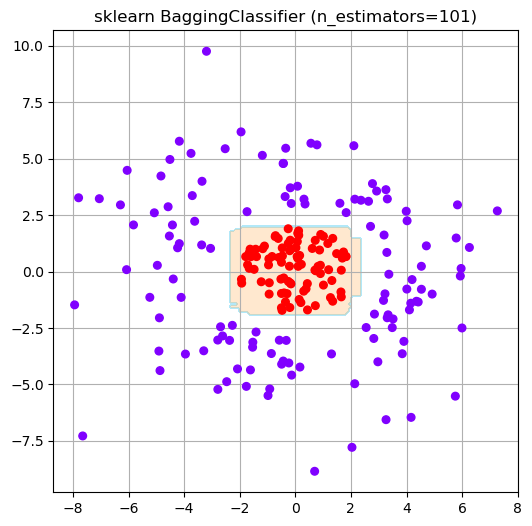

In [29]:
bag = BaggingClassifier(estimator=DecisionTreeClassifier(),
                        n_estimators=101,
                        max_samples=0.75,
                        bootstrap=True,
                        random_state=RS,
                        n_jobs=-1)
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)
acc_bag_sklearn = accuracy_score(y_test, bag_pred)
print(f"sklearn BaggingClassifier test accuracy ({bag.n_estimators} trees): {acc_bag_sklearn:.4f}")

plt.figure(figsize=(6,6))
visualize_classifier(bag, X_train, y_train)
plt.title(f"sklearn BaggingClassifier (n_estimators={bag.n_estimators})")
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
Sklearn BaggingClassifier managed to attain accuracy of almost 1 which once again demonstrates the effectiveness of ensemble approach
</div>